Classification of Architectural Heritage Elements via CNN  
MATH 6373: Final Project
By: Ray Thomas


## Initial Steps

In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback
%load_ext tensorboard

from sklearn.metrics import confusion_matrix
import itertools
import io
from math import sqrt

In [ ]:
# Function definitions for use in project

## Unzip uploaded files to respective folders
from zipfile import ZipFile
def unzip(file_path):
  with ZipFile(file_path, 'r') as zip:
      zip.extractall()
      print('Done')
  return

In [ ]:
# Download training & test dataset Zip Files 
# Source: "https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset"

!wget https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_64%28creative_commons%29_revised.zip \
!wget https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Dataset_test_AHE_64.zip \

#Unzip files to folders for use
unzip("/content/Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised.zip")
unzip("/content/Dataset_test_AHE_64.zip")

--2022-05-09 02:23:12--  https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_64%28creative_commons%29_revised.zip
Resolving correo.cartif.es (correo.cartif.es)... 130.206.13.100
Connecting to correo.cartif.es (correo.cartif.es)|130.206.13.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Cookie coming from correo.cartif.es attempted to set domain to sim.rediris.es
Length: 37597047 (36M) [application/zip]
Saving to: ‘Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised.zip’

Architectural_Herit 100%[===================>]  35.85M   658KB/s    in 58s     

2022-05-09 02:24:12 (635 KB/s) - ‘Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised.zip’ saved [37597047/37597047]

--2022-05-09 02:24:12--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2022-05-09 02:24:12--  https:/

In [ ]:
# # Convert all training data to numpy format

train_DATADIR = "/content/Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised"
train_CATEGORIES = ['bell_tower','column','dome(outer)','gargoyle','stained_glass','vault']

training_data = []

def create_training_data(DATADIR, CATEGORIES):
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        training_data.append([img_array, class_num])
      except Exception as e:
        pass

create_training_data(train_DATADIR, train_CATEGORIES)

In [ ]:
# Convert test data to numpy array
test_DATADIR = "/content/Dataset_test_64"
test_CATEGORIES = ['6_bell_tower','4_column','1_dome(outer)','5_gargoyle','3_stained_glass','7_vault']

test_data = []

def create_test_data(DATADIR, CATEGORIES):
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        test_data.append([img_array, class_num])
      except Exception as e:
        pass

create_test_data(test_DATADIR, test_CATEGORIES)

In [ ]:
# shuffle data 
import random

random.shuffle(training_data)
random.shuffle(test_data)

X_train = []
y_train = []
ytrain = []
X_test = []
y_test = []
ytest = []

L = []

for features, label in training_data:
  X_train.append(features)
  y_train.append(label)
  ytrain.append(label)



for features, label in test_data:
  X_test.append(features)
  y_test.append(label)
  ytest.append(label)

X_train = np.array(X_train).reshape(-1, 64, 64, 3)
y_train = to_categorical(y_train)
X_test = np.array(X_test).reshape(-1, 64, 64, 3)
y_test = to_categorical(y_test)

X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
# Balancing the classes using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,64,64,3)


test_rows = len(X_test)
X_test = X_test.reshape(test_rows,-1)
X_test, y_test = sm.fit_resample(X_test,y_test)
X_test = X_test.reshape(-1,64,64,3)

In [ ]:
ytrain = [np.argmax(y, axis=None, out=None) for y in y_train]
ytest = [np.argmax(y, axis=None, out=None) for y in y_test]

In [ ]:
num_categories = 6
num_training_obs = len(X_train)
num_infos = num_categories * num_training_obs
num_infos

68904

In [ ]:
batch_size = round(sqrt(len(X_train))/2)
batch_size

54

In [ ]:
def plot_confusion_matrix(cm, class_names, train = True):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if train == True:
      plt.title("Training Confusion matrix")
    else:
      plt.title("Test Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [ ]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [ ]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(X_test)
    
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = confusion_matrix(ytest, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=train_CATEGORIES)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [ ]:
def create_model(filter1, kernel1, pool1, filter2, kernel2, pool2, h, dropout = True, early_stopping = False):
  #NAME = f"model_C1-{filter1}X{kernel1}_MP1-{pool1}_C2-{filter2}X{kernel2}_MP2-{pool2}_h-{h}_{int(time.time())}"
  
  # Initialize CNN Model
  model = Sequential()

  # Convolutional Layer 1
  model.add(Conv2D(filters = filter1, kernel_size = kernel1, input_shape = X_train.shape[1:], activation = "relu"))
  model.add(MaxPooling2D(pool_size=pool1))

  # Convolutional Layer 2
  model.add(Conv2D(filters = filter2, kernel_size = kernel2, activation = "relu"))
  model.add(MaxPooling2D(pool_size=pool2))

  # Flattening Layer
  model.add(Flatten())

  # Hidden Layer with Dropout
  hidden = model.add(Dense(h, activation = "relu"))
  if dropout == True:
    model.add(Dropout(0.50))

  # Final Layer and Softmax Activation
  model.add(Dense(6, activation ="softmax"))

  model.summary()
  
  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  
  #tensorboard = TensorBoard(log_dir=f"logs/{NAME}")
  #cm_callback = LambdaCallback(on_epoch_end=log_confusion_matrix)
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  from math import sqrt
  if early_stopping == False:
    history = model.fit(X_train,
                        y_train,
                        batch_size = round(sqrt(len(X_train))), 
                        epochs = 100,
                        verbose=1,
                        validation_split = 0.2)#,
                        #callbacks = [early_stop]) #[tensorboard]) #, cm_callback])
  else:
    history = model.fit(X_train,
                        y_train,
                        batch_size = round(sqrt(len(X_train))), 
                        epochs = 100,
                        verbose=1,
                        validation_split = 0.2,
                        callbacks = [early_stop])

  


  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('loss function')
  plt.ylabel('loss function')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  #training predictions & matrix
  train_pred_raw = model.predict(X_train)    
  train_pred = np.argmax(train_pred_raw, axis=1)
  # Calculate the confusion matrix using sklearn.metrics
  cm = confusion_matrix(ytrain, train_pred)
  figure = plot_confusion_matrix(cm, class_names=train_CATEGORIES, train = True)

  score1 = model.evaluate(X_train, y_train)
  print(f'Training loss: {score1[0]} / Training accuracy: {score1[1]}')
  
  #test predictions & matrix
  test_pred_raw = model.predict(X_test)    
  test_pred = np.argmax(test_pred_raw, axis=1)
  # Calculate the confusion matrix using sklearn.metrics
  cm = confusion_matrix(ytest, test_pred)
  figure = plot_confusion_matrix(cm, class_names=train_CATEGORIES, train = False)
  #cm_image = plot_to_image(figure)

  score2 = model.evaluate(X_test, y_test)
  print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')


  return


In [ ]:
# %tensorboard --logdir logs

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.99, svd_solver='full')
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

## Models with h = sqrt(dim(flattened_layer))/2, dropout = True

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 40)                2

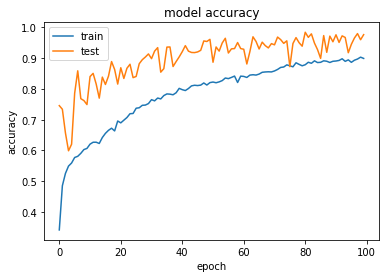

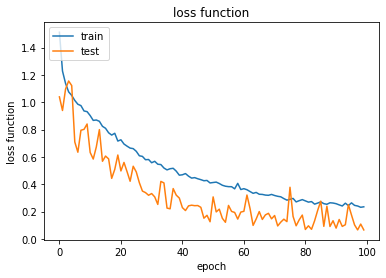

359/359 [==============================] - 2s 5ms/step - loss: 0.0329 - accuracy: 0.9903
Training loss: 0.032881297171115875 / Training accuracy: 0.9903343915939331
45/45 [==============================] - 0s 6ms/step - loss: 1.2179 - accuracy: 0.7882
Test loss: 1.2179152965545654 / Test accuracy: 0.7881944179534912


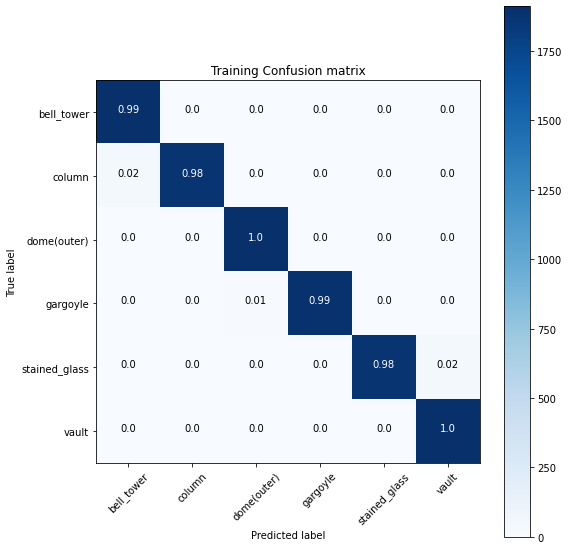

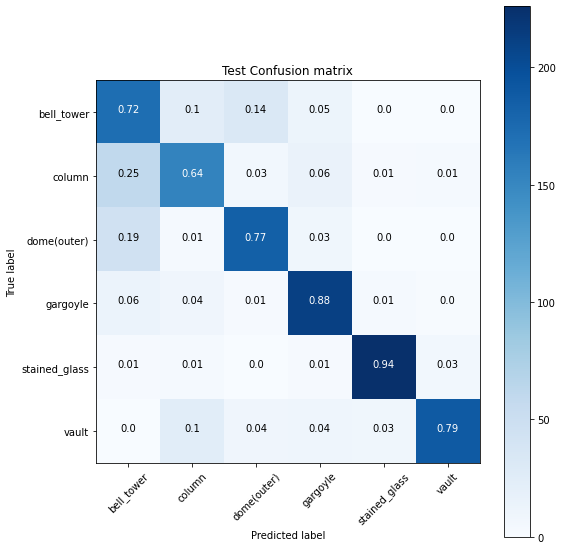

In [ ]:
create_model(32,3,2,32,3,2,round(sqrt(6272)/2))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 56)               

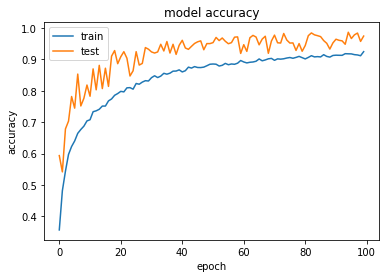

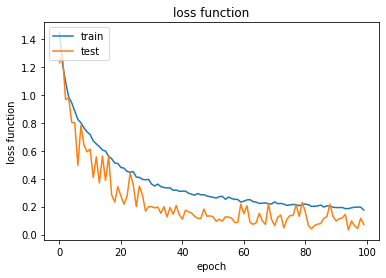

359/359 [==============================] - 2s 6ms/step - loss: 0.0215 - accuracy: 0.9926
Training loss: 0.021523961797356606 / Training accuracy: 0.9925984144210815
45/45 [==============================] - 0s 6ms/step - loss: 1.2058 - accuracy: 0.8076
Test loss: 1.2057698965072632 / Test accuracy: 0.8076388835906982


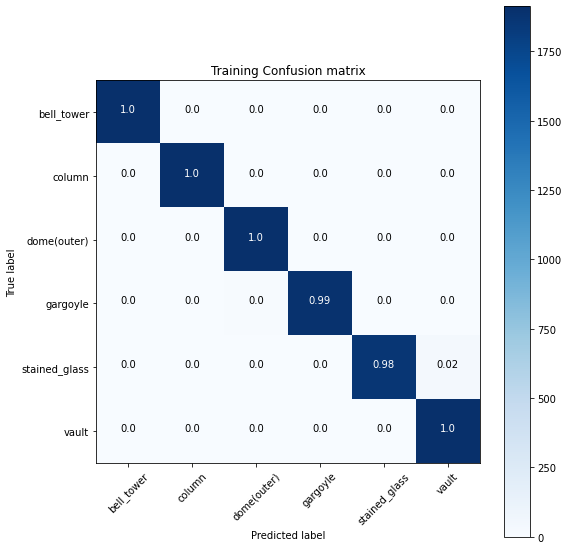

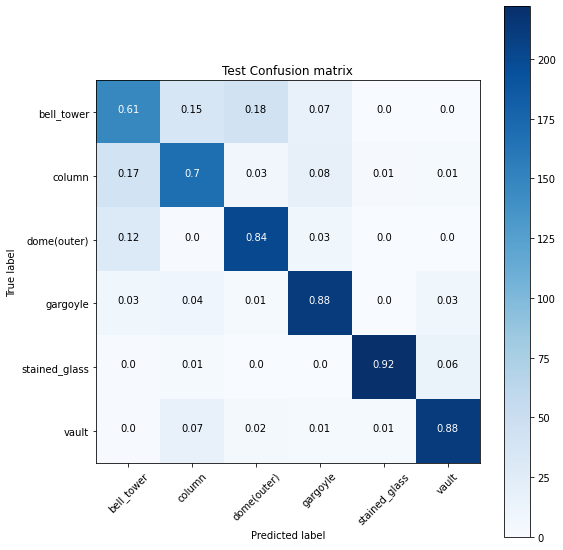

In [ ]:
create_model(32,3,2,64,3,2,round(sqrt(12544)/2))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 56)               

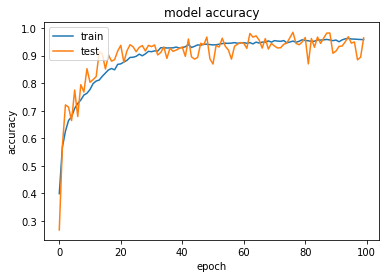

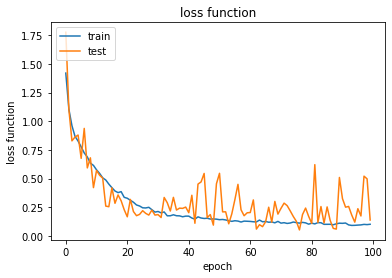

359/359 [==============================] - 3s 8ms/step - loss: 0.0305 - accuracy: 0.9916
Training loss: 0.030522294342517853 / Training accuracy: 0.991640567779541
45/45 [==============================] - 0s 8ms/step - loss: 1.5432 - accuracy: 0.7972
Test loss: 1.543233871459961 / Test accuracy: 0.7972221970558167


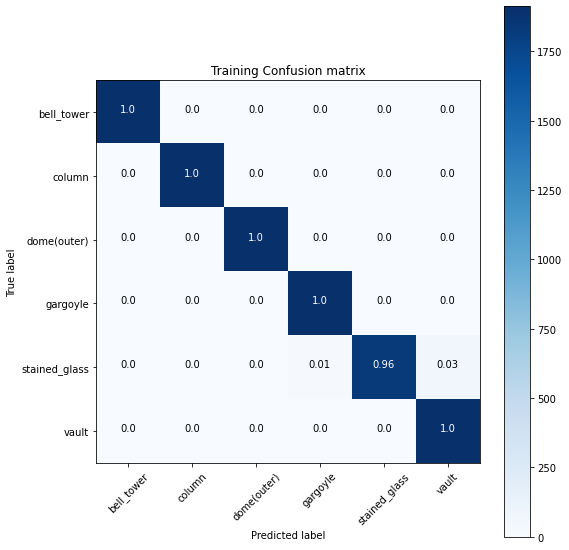

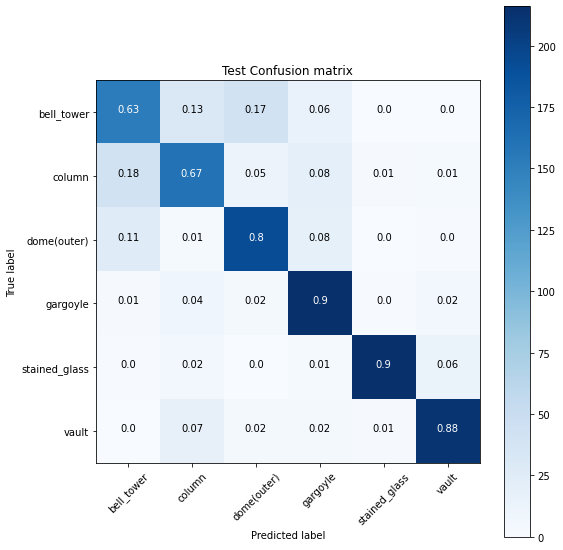

In [ ]:
create_model(64,3,2,64,3,2,round(sqrt(12544)/2))

## Models using Parsimony principle to determine h-values

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_12 (Dense)            (None, 9)                

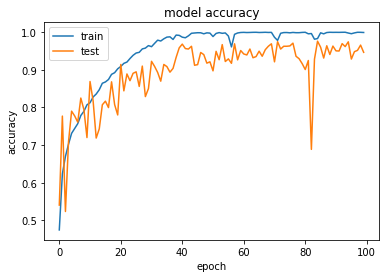

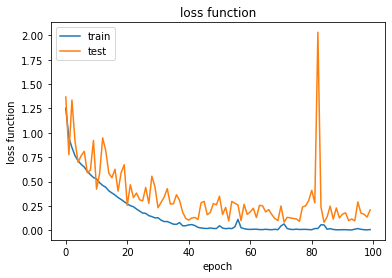

359/359 [==============================] - 2s 6ms/step - loss: 0.0452 - accuracy: 0.9890
Training loss: 0.045206982642412186 / Training accuracy: 0.9890282154083252
45/45 [==============================] - 0s 6ms/step - loss: 1.7793 - accuracy: 0.7549
Test loss: 1.7793341875076294 / Test accuracy: 0.7548611164093018


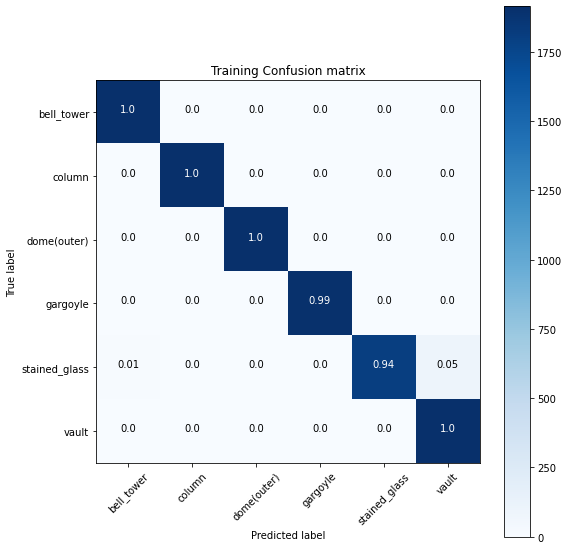

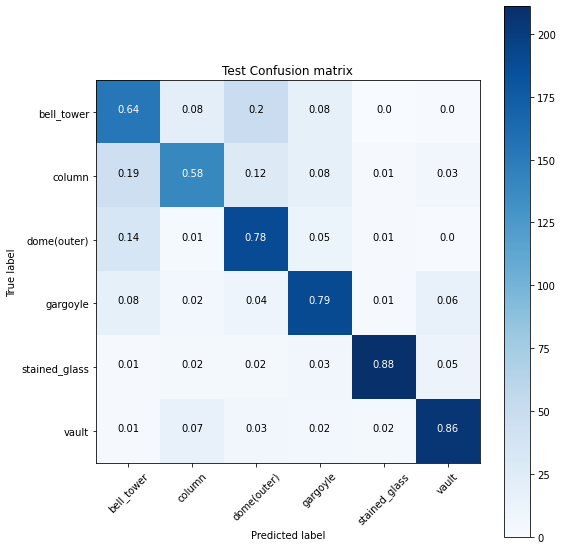

In [ ]:
create_model(32,3,2,32,3,2,9, dropout = False)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 12544)             0         
                                                                 
 dense_14 (Dense)            (None, 3)                

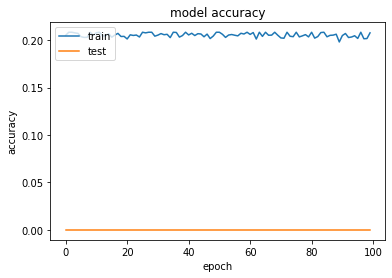

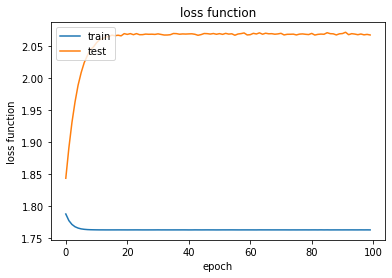

359/359 [==============================] - 2s 6ms/step - loss: 1.8231 - accuracy: 0.1667
Training loss: 1.823064923286438 / Training accuracy: 0.1666666716337204
45/45 [==============================] - 0s 7ms/step - loss: 1.8231 - accuracy: 0.1667
Test loss: 1.8230682611465454 / Test accuracy: 0.1666666716337204


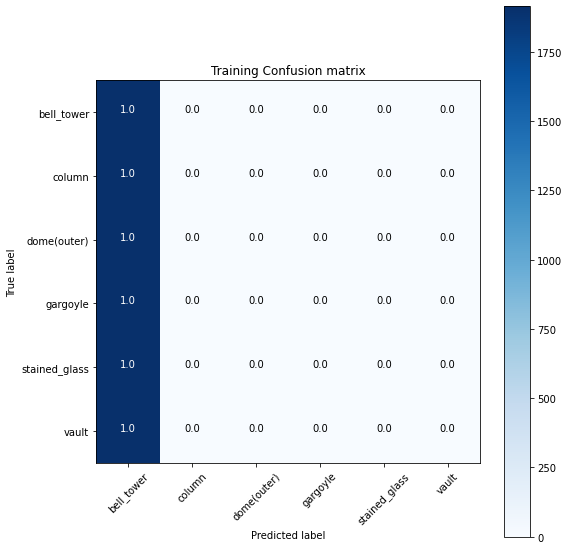

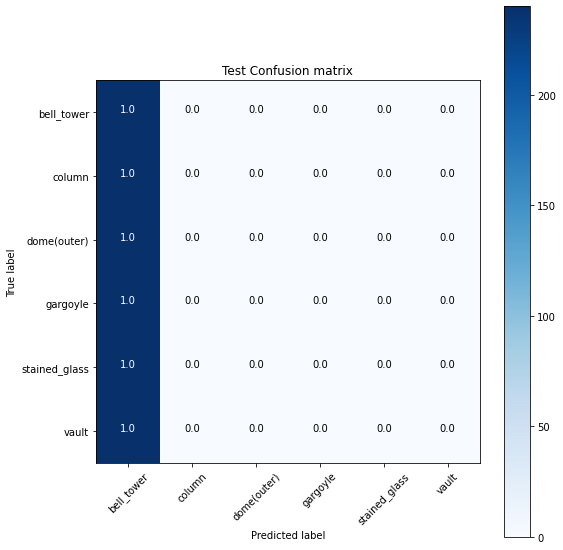

In [ ]:
create_model(32,3,2,64,3,2,3, dropout = False)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 12544)             0         
                                                                 
 dense_16 (Dense)            (None, 2)                

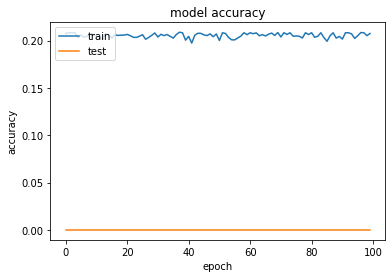

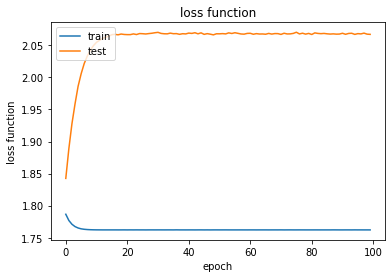

359/359 [==============================] - 3s 9ms/step - loss: 1.8231 - accuracy: 0.1667
Training loss: 1.8230934143066406 / Training accuracy: 0.1666666716337204
45/45 [==============================] - 1s 9ms/step - loss: 1.8231 - accuracy: 0.1667
Test loss: 1.8230959177017212 / Test accuracy: 0.1666666716337204


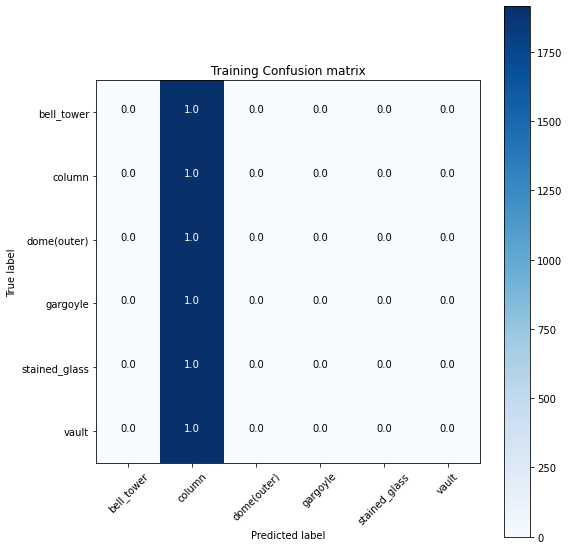

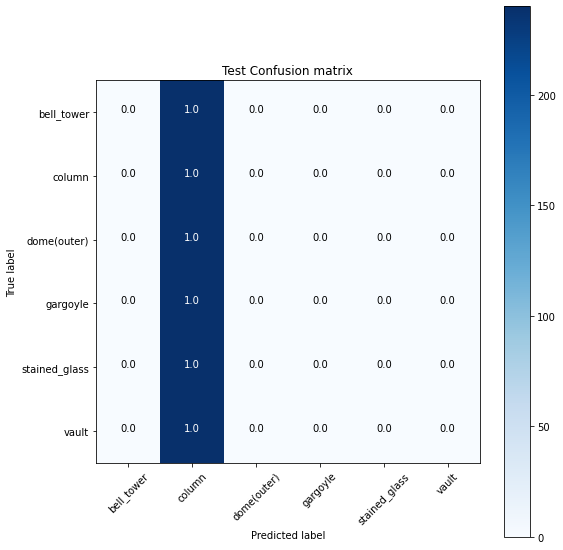

In [ ]:
create_model(64,3,2,64,3,2,2, dropout = False)

## Models with minimum of 6 hidden layers

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 12544)             0         
                                                                 
 dense_18 (Dense)            (None, 6)                

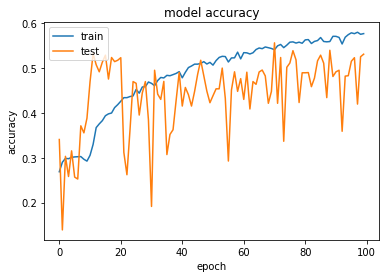

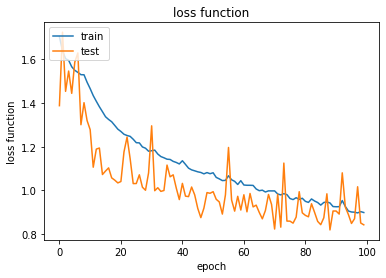

359/359 [==============================] - 2s 6ms/step - loss: 0.8782 - accuracy: 0.5721
Training loss: 0.8781525492668152 / Training accuracy: 0.5721003413200378
45/45 [==============================] - 0s 7ms/step - loss: 1.5148 - accuracy: 0.4319
Test loss: 1.514758586883545 / Test accuracy: 0.43194442987442017


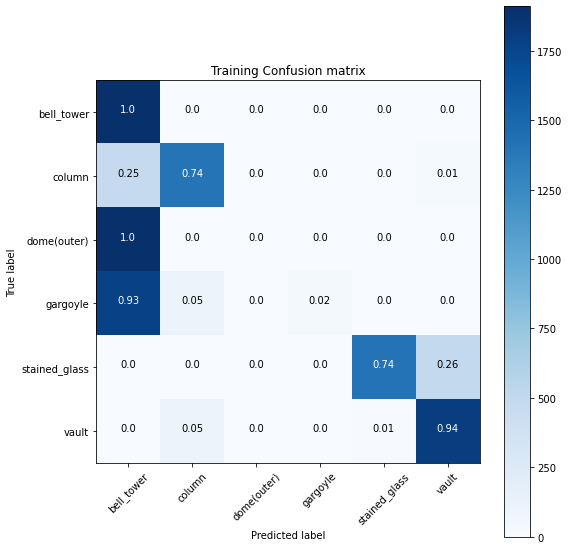

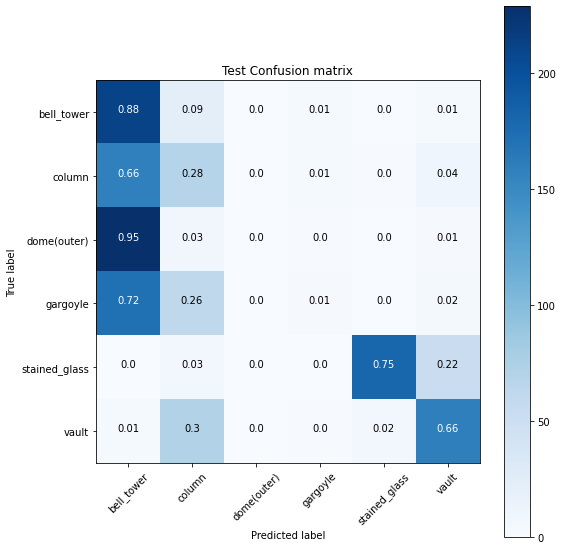

In [ ]:
create_model(32,3,2,64,3,2,6, dropout = False)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 12544)             0         
                                                                 
 dense_20 (Dense)            (None, 6)               

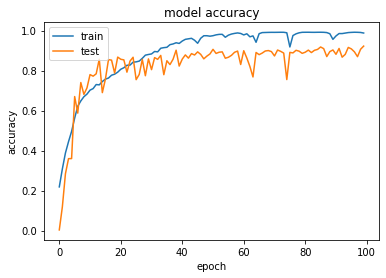

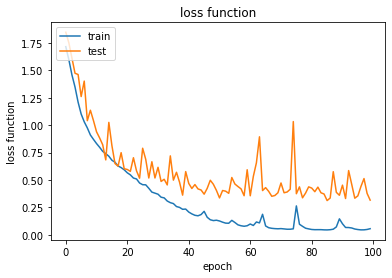

359/359 [==============================] - 3s 9ms/step - loss: 0.1099 - accuracy: 0.9739
Training loss: 0.10991853475570679 / Training accuracy: 0.9738767147064209
45/45 [==============================] - 1s 10ms/step - loss: 4.3818 - accuracy: 0.6542
Test loss: 4.381782054901123 / Test accuracy: 0.6541666388511658


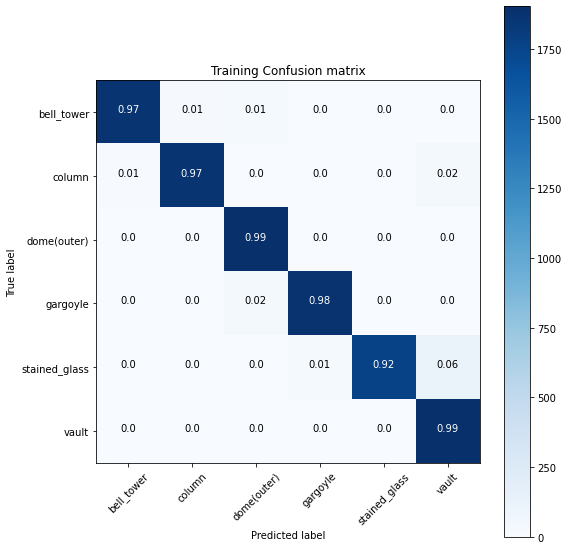

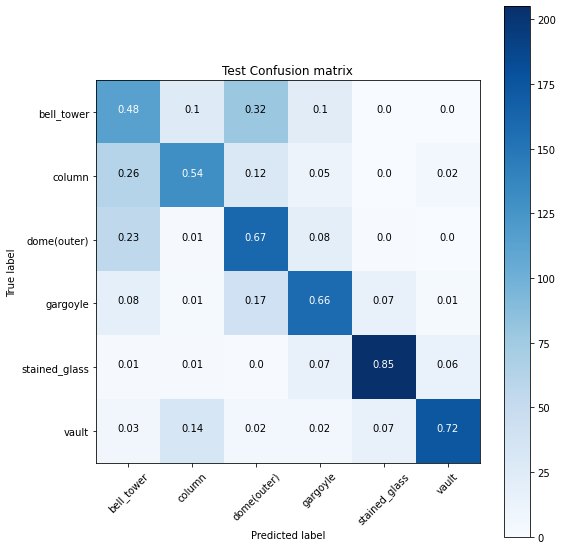

In [ ]:
create_model(64,3,2,64,3,2,6, dropout = False)

## Best 2 models with EarlyStopping()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 12544)             0         
                                                                 
 dense_32 (Dense)            (None, 56)              

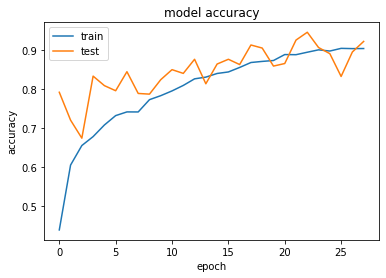

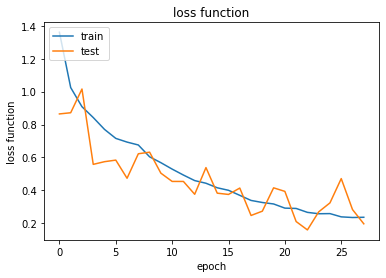

359/359 [==============================] - 3s 7ms/step - loss: 0.0775 - accuracy: 0.9763
Training loss: 0.07745140790939331 / Training accuracy: 0.976314902305603
45/45 [==============================] - 0s 7ms/step - loss: 0.7220 - accuracy: 0.8118
Test loss: 0.7219769954681396 / Test accuracy: 0.8118055462837219


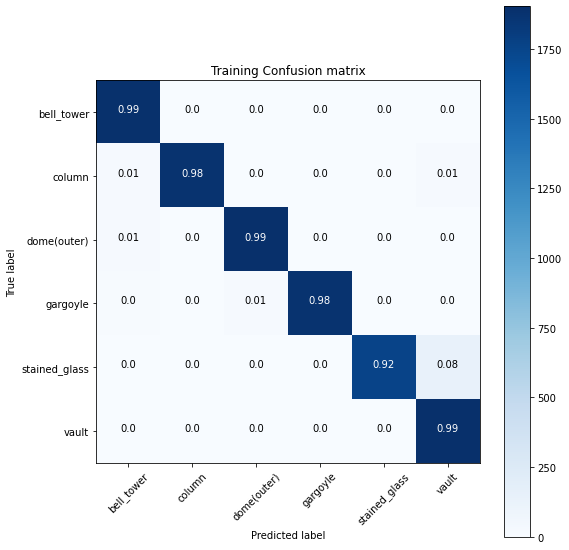

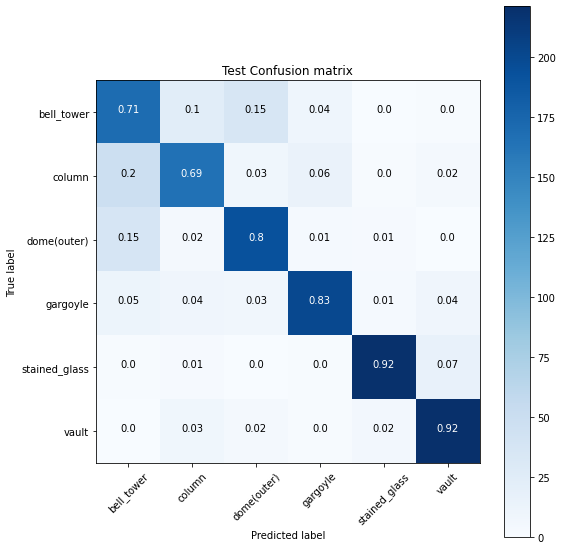

In [ ]:
create_model(32,3,2,64,3,2,round(sqrt(12544)/2), early_stopping = True)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 12544)             0         
                                                                 
 dense_34 (Dense)            (None, 56)              

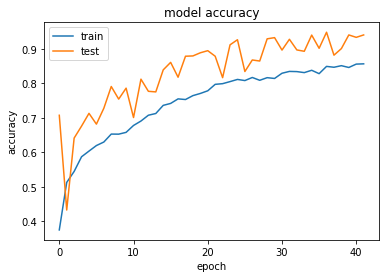

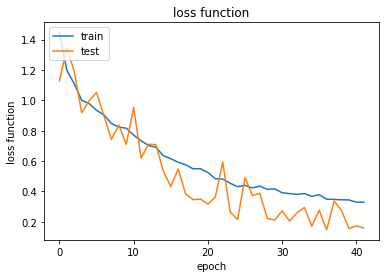

359/359 [==============================] - 3s 8ms/step - loss: 0.0750 - accuracy: 0.9760
Training loss: 0.07500675320625305 / Training accuracy: 0.9759665727615356
45/45 [==============================] - 1s 9ms/step - loss: 0.7960 - accuracy: 0.7944
Test loss: 0.7960227727890015 / Test accuracy: 0.7944444417953491


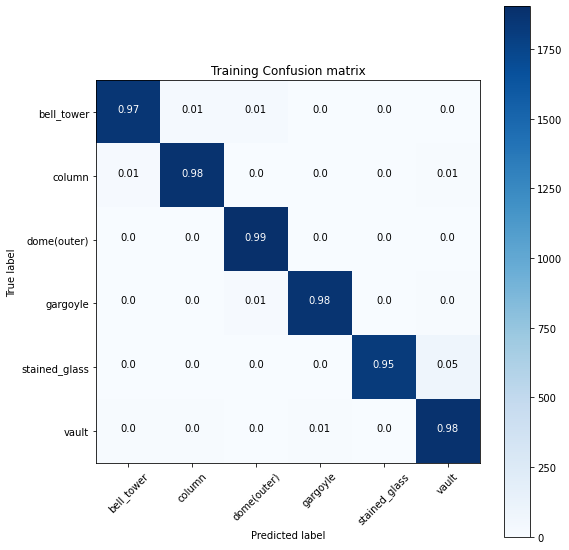

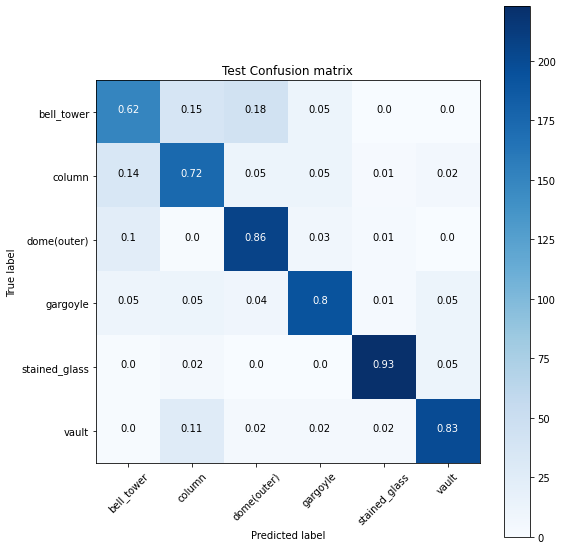

In [ ]:
create_model(64,3,2,64,3,2,round(sqrt(12544)/2), early_stopping = True)

## Miscellaneous code

In [ ]:
def create_model2(filter1, kernel1, pool1, filter2, kernel2, pool2, h):
  #NAME = f"model_C1-{filter1}X{kernel1}_MP1-{pool1}_C2-{filter2}X{kernel2}_MP2-{pool2}_h-{h}_{int(time.time())}"
  
  # Initialize CNN Model
  model = Sequential()

  # Convolutional Layer 1
  model.add(Conv2D(filters = filter1, kernel_size = kernel1, input_shape = X_train.shape[1:], activation = "relu"))
  model.add(MaxPooling2D(pool_size=pool1))

  # Convolutional Layer 2
  model.add(Conv2D(filters = filter2, kernel_size = kernel2, activation = "relu"))
  model.add(MaxPooling2D(pool_size=pool2))

  # Flattening Layer
  model.add(Flatten())

  # Hidden Layer with Dropout
  hidden = model.add(Dense(h, activation = "relu"))
  model.add(Dropout(0.20))

  # Final Layer and Softmax Activation
  model.add(Dense(6, activation ="softmax"))
  
  model.summary()


In [ ]:
model4 = create_model2(filter1=32, kernel1=3, pool1=2, filter2=64, kernel2=3, pool2=2, h=3)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 12544)             0         
                                                                 
 dense_22 (Dense)            (None, 3)               

In [ ]:
num_infos

68904

In [ ]:
tf.keras.backend.clear_session()